Training GRU model...
Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 29s 95ms/step - accuracy: 0.5557 - auc: 0.5692 - loss: 0.8623 - val_accuracy: 0.5798 - val_auc: 0.7457 - val_loss: 0.6660 - learning_rate: 0.0010
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 29s 108ms/step - accuracy: 0.7192 - auc: 0.8000 - loss: 0.5435 - val_accuracy: 0.6936 - val_auc: 0.7753 - val_loss: 0.5638 - learning_rate: 0.0010
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - accuracy: 0.8254 - auc: 0.9027 - loss: 0.4058 - val_accuracy: 0.6870 - val_auc: 0.7995 - val_loss: 0.6293 - learning_rate: 0.0010
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - accuracy: 0.8803 - auc: 0.9431 - loss: 0.3119 - val_accuracy: 0.6698 - val_auc: 0.7949 - val_loss: 0.8750 - learning_rate: 0.0010
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step - accuracy: 0.9089 - auc: 0.9619 - loss: 0.2545 - val_accuracy: 0.6898 - val_auc: 0.7857 - val_loss: 0.8674 - learning_rate: 0.0010
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 29s 

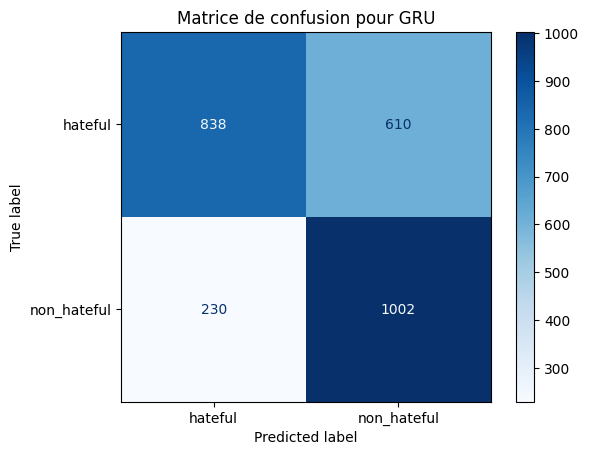

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import RMSprop


# Chargement des données
data = pd.read_csv('./data/cleaned_combined_dataset.csv')  # Assurez-vous d'avoir un fichier CSV contenant vos données
texts = data['text'].astype(str).values
labels = data['label'].values

# Prétraitement des étiquettes
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Tokenization et padding des séquences
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

# Split des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Définition des hyperparamètres
embedding_dim = 100
vocab_size = 10000
max_length = 200

# Ajoutez un learning rate scheduler
def lr_schedule(epoch):
    return 0.001 * (0.1 ** int(epoch / 10))

# Fonction pour créer un modèle LSTM
def create_lstm_model():
    model = Sequential([
        Embedding(vocab_size, embedding_dim),
        (LSTM(128, return_sequences=True, kernel_regularizer=l2(1e-6))),
        BatchNormalization(),
        Dropout(0.3),
        (LSTM(64, kernel_regularizer=l2(1e-6))),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_regularizer=l2(1e-6)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=RMSprop(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy', AUC(name='auc')])
    return model


# Fonction pour créer un modèle BiLSTM
def create_bilstm_model():
    model = Sequential([
        Embedding(vocab_size, embedding_dim),
        Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-5))),
        BatchNormalization(),
        Dropout(0.5),
        Bidirectional(LSTM(32, kernel_regularizer=l2(1e-5))),
        BatchNormalization(),
        Dropout(0.5),
        Dense(16, activation='relu', kernel_regularizer=l2(1e-5)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=5e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Fonction pour créer un modèle GRU
def create_gru_model():
    model = Sequential([
        Embedding(vocab_size, embedding_dim),
        Bidirectional(GRU(64, return_sequences=True, kernel_regularizer=l2(1e-5))),
        BatchNormalization(),
        Dropout(0.4),
        Bidirectional(GRU(32, return_sequences=False, kernel_regularizer=l2(1e-5))),
        BatchNormalization(),
        Dropout(0.4),
        Dense(16, activation='relu', kernel_regularizer=l2(1e-5)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=5e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy', AUC(name='auc')])
    return model

""" # Entraînement des modèles
models = {
    'LSTM': create_lstm_model(),
    'BiLSTM': create_bilstm_model(),
    'GRU': create_gru_model()
} """

# Entraînement des modèles
models = {
    'GRU': create_gru_model()
}

callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True), LearningRateScheduler(lr_schedule)]

for model_name, model in models.items():
    print(f'Training {model_name} model...')
    model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32, callbacks=callbacks)
    test_results = model.evaluate(X_test, y_test)
    loss = test_results[0]
    accuracy = test_results[1]
    print(f'{model_name} Model - Loss: {loss}, Accuracy: {accuracy}')

    # Générer des prédictions
    y_pred = (model.predict(X_test) > 0.5).astype("int32")

    # Calculer la matrice de confusion
    cm = confusion_matrix(y_test, y_pred)

    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Accuracy Score:", accuracy_score(y_test, y_pred))

    # Afficher la matrice de confusion
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Matrice de confusion pour {model_name}')
    plt.show()

# Sauvegarde des modèles entraînés
for model_name, model in models.items():
    model.save(f'./models/{model_name}_model.keras')
